Aim: predict age and gender from RFIW2021 data -- train and val sets.

1. Inspect MiVOLO to understand its setup
2. Copy the necessary code
3. Adapt it to save each prediction to a dataframe (maybe extending val.txt to have age and gender)
4. Analyse the generated dataframe

## Import libraries

In [1]:
from dataclasses import dataclass
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mivolo.data.data_reader import get_all_files
from mivolo.predictor import Predictor
from tqdm import tqdm

In [2]:
%load_ext jupyter_ai_magics

# Set up paths

In [3]:
try:
    IS_NOTEBOOK = True
    HERE = Path(__file__).resolve().parent
except NameError:
    IS_NOTEBOOK = False
    HERE = Path().resolve()

TRAIN_DATA_DIR = Path(HERE, "../rfiw2021/Track1/Train/train-faces")
VAL_DATA_DIR = Path(HERE, "../rfiw2021/Track1/Validation/val-faces")
MODELS_DIR = Path(HERE, "../MiVOLO/models")

Path("data").mkdir(exist_ok=True)

In [4]:
@dataclass
class Config:
    device: str = "cuda"
    detector_weights: str = MODELS_DIR / "yolov8x_person_face.pt"
    checkpoint: str = MODELS_DIR / "mivolo_imbd.pth.tar"
    with_persons: bool = False
    disable_faces: bool = False
    draw = False

In [5]:
args = Config()
predictor = Predictor(args)

Model summary (fused): 268 layers, 68125494 parameters, 0 gradients


In [6]:
def compute_ag_preds(csv_path, data_dir, load_preds=True):
    if csv_path.exists() and LOAD_PREDS:
        ag_preds = pd.read_csv(csv_path)
    else:
        image_files = get_all_files(data_dir)

        preds = []

        for img_p in tqdm(image_files):
            img = cv2.imread(img_p)
            try:
                pred, out_im = predictor.recognize(img)
                gs = np.array(pred.gender_scores)
                gs[gs == None] = 0
                max_index = np.argmax(gs)
                if pred.ages[max_index] is None:
                    pred_info = {"age": 0, "gender": "unk", "gender_score": 0}
                else:
                    pred_info = {
                        "age": pred.ages[max_index],
                        "gender": pred.genders[max_index],
                        "gender_score": pred.gender_scores[max_index],
                    }
            except:
                pred_info = {"age": 0, "gender": "unk", "gender_score": 0}
            img_info = {k: v for k, v in zip(["fid", "mid", "pid_filename"], Path(img_p).parts[-3:])}
            preds.append({**img_info, **pred_info})

        ag_preds = pd.DataFrame(preds)
        ag_preds.to_csv(csv_path, index=False)

        print(f"Errors found: {len(ag_preds[ag_preds.age == 0])}")

    return ag_preds

In [7]:
LOAD_PREDS = True
train_ag_preds_csv_path = Path("data/train_age_gender_predictions.csv")
train_ag_preds = compute_ag_preds(train_ag_preds_csv_path, TRAIN_DATA_DIR, load_preds=LOAD_PREDS)
assert train_ag_preds_csv_path.exists()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15845/15845 [10:08<00:00, 26.03it/s]

Errors found: 517


In [9]:
LOAD_PREDS = True
val_ag_preds_csv_path = Path("data/val_age_gender_predictions.csv")
val_ag_preds = compute_ag_preds(val_ag_preds_csv_path, VAL_DATA_DIR, load_preds=LOAD_PREDS)
assert val_ag_preds_csv_path.exists()

In [10]:
def plot_unknowns(ag_preds, data_dir):
    fig, axes = plt.subplots(5, 20, figsize=(20, 5))
    axes = [ax for axes_ in axes for ax in axes_]

    errors = ag_preds[ag_preds.gender == "unk"].sample(n=100).reset_index(drop=True)

    for idx, row in errors.iterrows():
        img_fp = str(Path(data_dir, row.fid, row.mid, row.pid_filename).resolve())
        img = cv2.imread(img_fp)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = axes[idx]
        ax.imshow(img)
        ax.axis("off")

    plt.show()

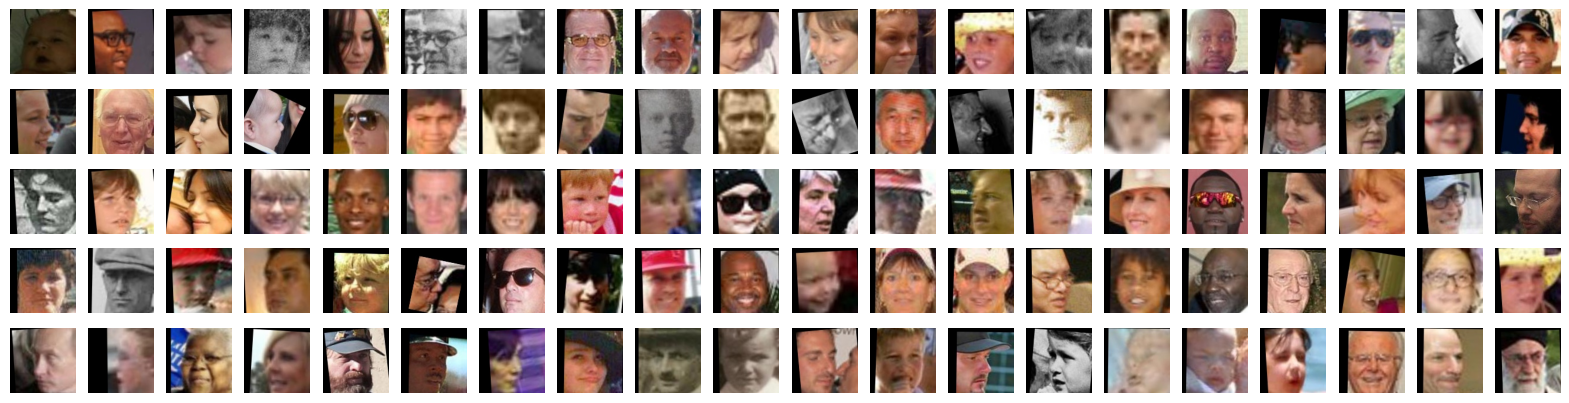

In [12]:
plot_unknowns(train_ag_preds, TRAIN_DATA_DIR)

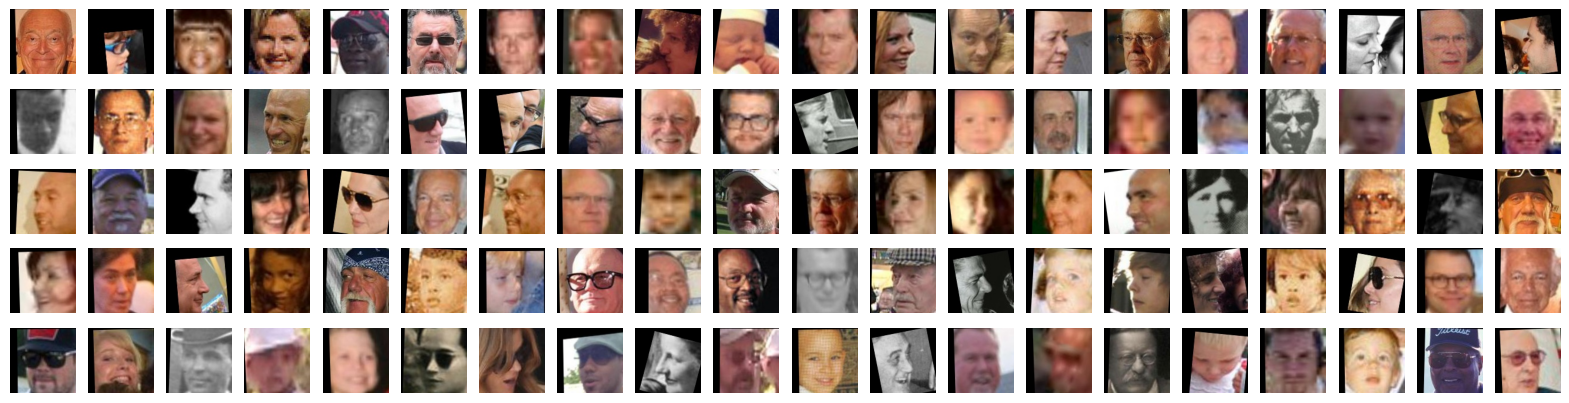

In [13]:
plot_unknowns(val_ag_preds, VAL_DATA_DIR)

# Data Analysis

- Age histogram for each kinship relation, for each face image
- Gender histogram for each kinship relation, for each face index

We are supposing that there are no intersections between faces in the pairs. That is, first faces aren't present as second faces in any other pair.

What I found while coding:

1. Face pairs with repeated faces are possible for face 1.

### Steps

1. Load validation pairs info into a dataframe: `val_pairs`
2. Extract FID, MID, filename to new columns
3. Merge age and gender predictions `ag_preds` with `val_pairs`
   - New dataframe will have: `face1_path, face2_path, kin_relation, is_kin, face1_family_id (fid1), face2_family_id (fid2), pid1_age, pid1_gender, pid2_age, pid2_gender`
4. Plot histograms: a unique plot with 2 subplots, where row 1 has age and row 2 has gender for both faces histogram densitys overlaid

## Plot data distribution

In [15]:
def plot_ag_preds_summary(ag_preds):
    plt.figure(figsize=(12, 4))

    # Plot for 'age'
    plt.subplot(1, 3, 1)
    ag_preds["age"].plot(kind="hist", bins=30, edgecolor="black")
    plt.xlabel("Age")
    plt.title("Age Distribution")

    # Plot for 'gender'
    plt.subplot(1, 3, 2)
    ag_preds["gender"].value_counts().plot(kind="bar", color="orange")
    plt.xlabel("Gender")
    plt.title("Gender Distribution")

    # Plot for 'gender_score'
    plt.subplot(1, 3, 3)
    ag_preds["gender_score"].plot(kind="hist", color="green")
    plt.xlabel("Gender Score")
    plt.title("Gender Score Distribution")

    plt.tight_layout()
    plt.show()

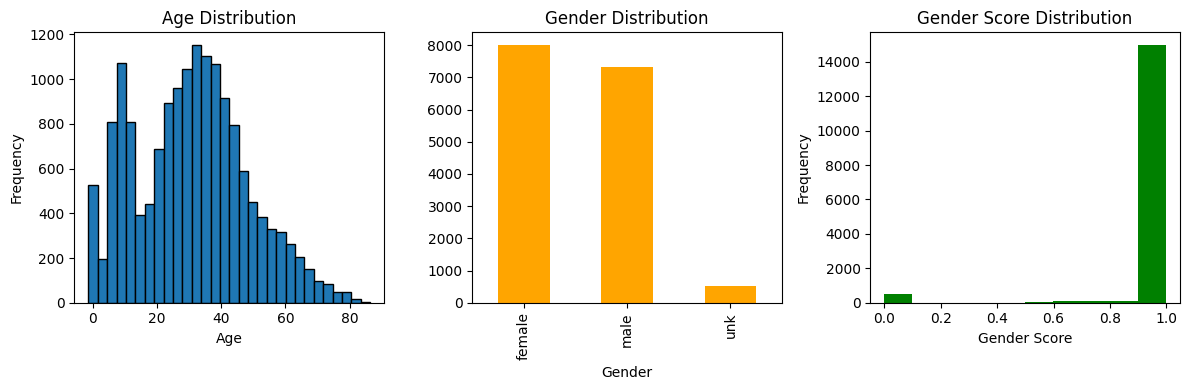

In [16]:
plot_ag_preds_summary(train_ag_preds)

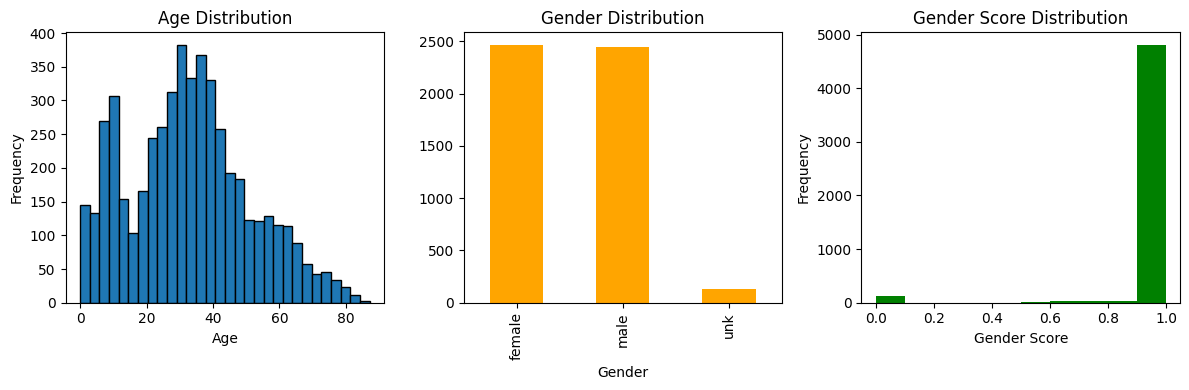

In [17]:
plot_ag_preds_summary(val_ag_preds)

## Plot some 0-age samples

In [18]:
def plot_zero_age_samples(errors, data_dir, title):
    fig, axes = plt.subplots(5, 20, figsize=(20, 5))
    axes = [ax for axes_ in axes for ax in axes_]

    for idx, row in errors.iterrows():
        img_fp = str(Path(data_dir, row.fid, row.mid, row.pid_filename).resolve())
        img = cv2.imread(img_fp)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = axes[idx]
        ax.imshow(img)
        ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

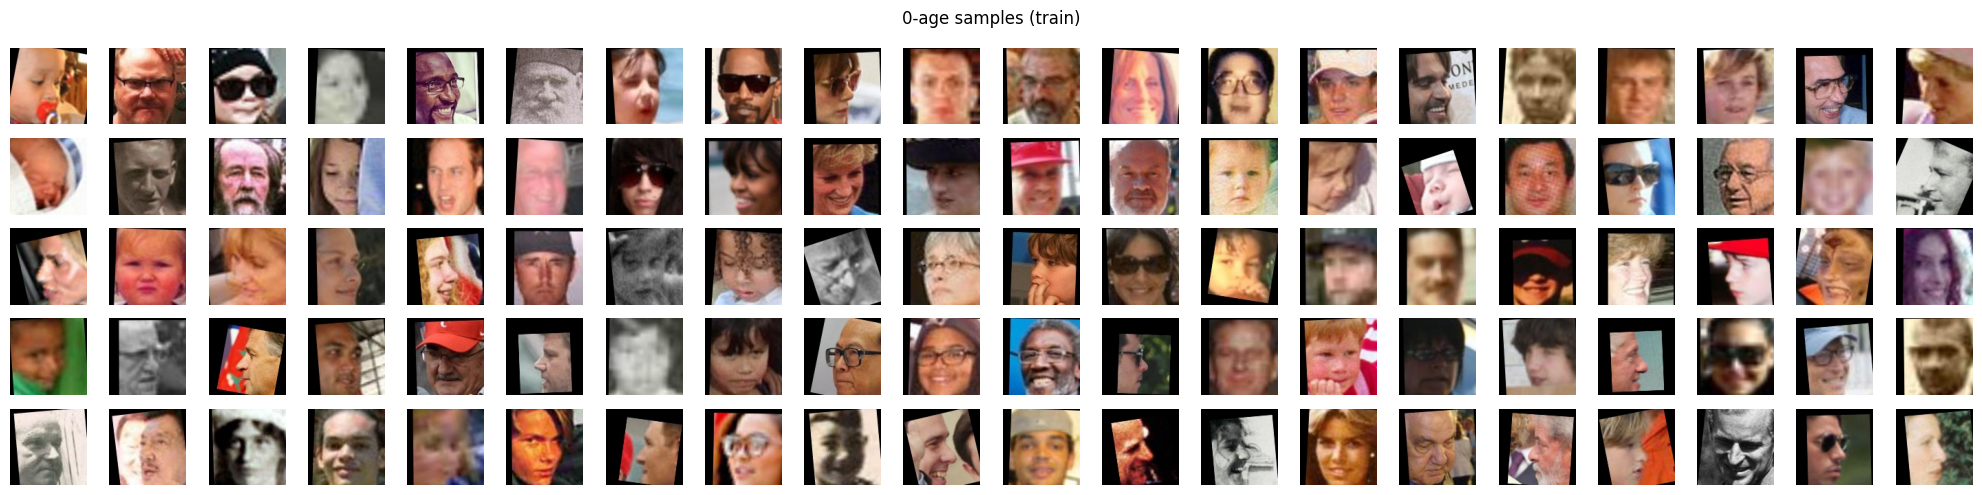

In [19]:
train_errors = train_ag_preds[train_ag_preds.age == 0].sample(n=100).reset_index(drop=True)
plot_zero_age_samples(train_errors, TRAIN_DATA_DIR, "0-age samples (train)")

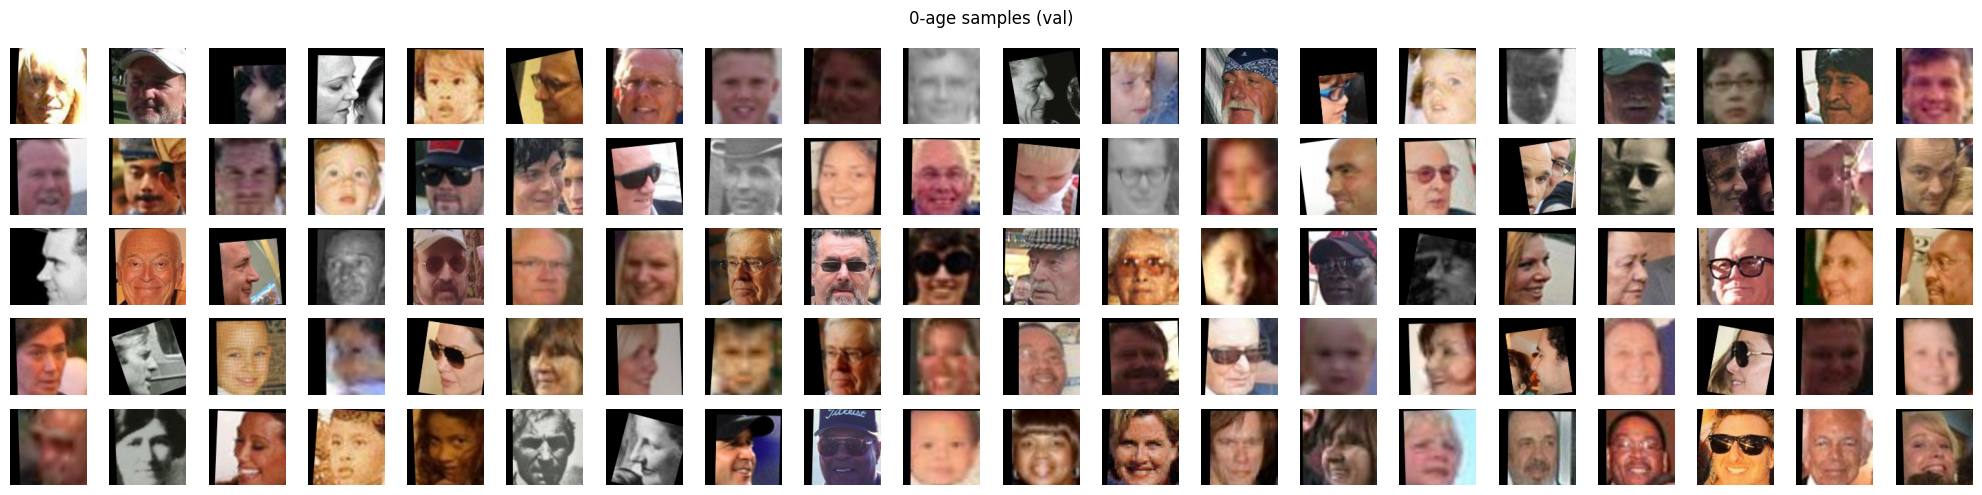

In [20]:
val_errors = val_ag_preds[val_ag_preds.age == 0].sample(n=100).reset_index(drop=True)
plot_zero_age_samples(val_errors, VAL_DATA_DIR, "0-age samples (val)")

In [26]:
def plot_random_error_sample(errors, data_dir):
    sample = errors.sample(n=1).iloc[0]
    img_fp = str(Path(data_dir, sample.fid, sample.mid, sample.pid_filename).resolve())
    img = cv2.imread(img_fp)
    results, _ = predictor.recognize(img)
    print(results.ages, results.genders, results.gender_scores)
    plot_img = results.plot(line_width=1, font_size=5)
    plot_img = cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB)
    plt.imshow(plot_img)

[] [] []


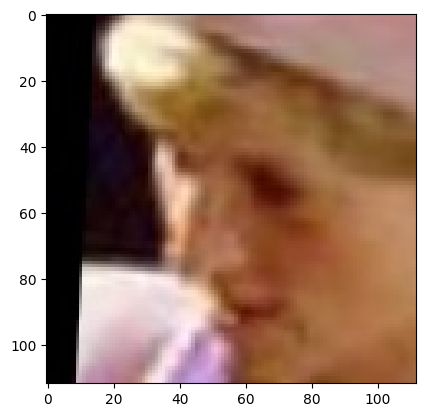

In [27]:
plot_random_error_sample(train_errors, TRAIN_DATA_DIR)

[] [] []


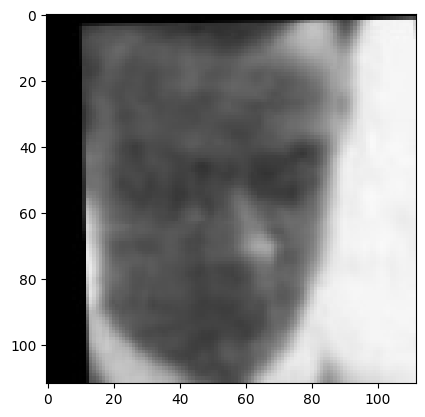

In [29]:
plot_random_error_sample(val_errors, VAL_DATA_DIR)

## Filter 0-age samples, then plot data distributions again

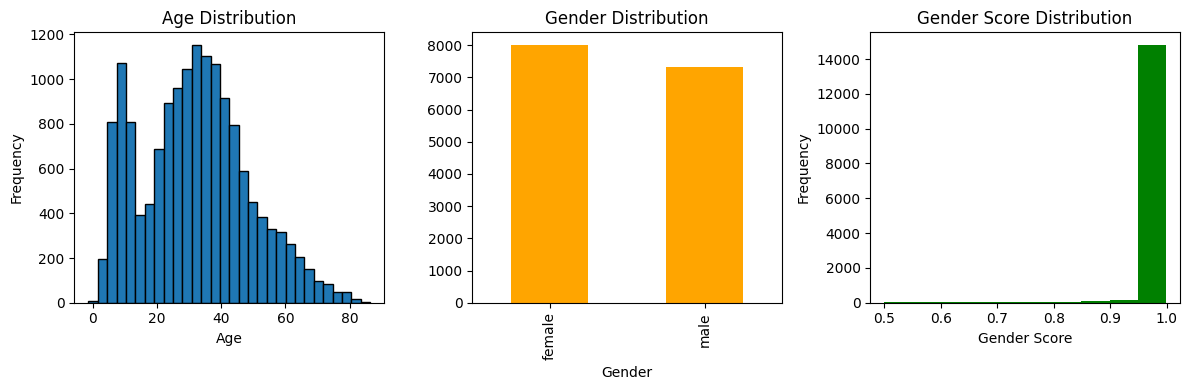

In [30]:
temp_t_ag_preds = train_ag_preds.copy()
ag_preds = temp_t_ag_preds[temp_t_ag_preds.age != 0]
plot_ag_preds_summary(ag_preds)

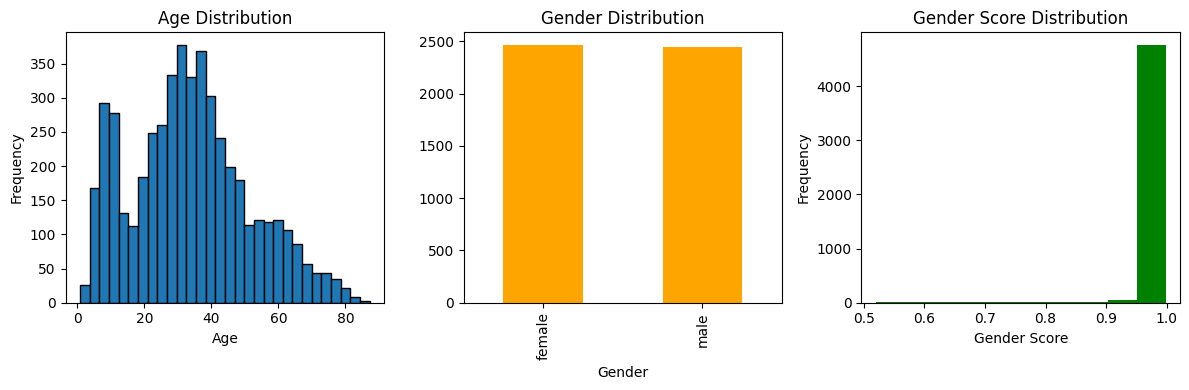

In [31]:
temp_v_ag_preds = val_ag_preds.copy()
ag_preds = temp_v_ag_preds[temp_v_ag_preds.age != 0]
plot_ag_preds_summary(ag_preds)

## Load validation pairs

In [32]:
def load_data(path: str | Path):
    df = pd.read_csv(
        path,
        delimiter=" ",
        header=None,
        names=["id", "face1_path", "face2_path", "kin_relation", "is_kin"],
    )
    df.drop(["id"], inplace=True, axis=1)
    return df

In [35]:
def load_pairs(*file_paths):
    df_list = [load_data(Path(HERE, path)) for path in file_paths]
    pairs = pd.concat(df_list).reset_index(drop=True)
    return pairs


def load_train_pairs():
    return load_pairs("../rfiw2021/Track1/sample0/train_sort.txt")


def load_val_pairs():
    return load_pairs("../rfiw2021/Track1/sample0/val.txt", "../rfiw2021/Track1/sample0/val_choose.txt")

In [37]:
train_pairs = load_train_pairs()
val_pairs = load_val_pairs()

## Plot frequency by `kin_relation`

In [41]:
import warnings

import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
sns.set(style="darkgrid")


def plot_kin_relation_freqs(pairs, title):
    # Calculate frequencies of 'kin_relation'
    kin_relation_frequencies = pairs["kin_relation"].value_counts().index.tolist()

    # Reorder 'kin_relation' based on frequency
    pairs["kin_relation"] = pd.Categorical(pairs["kin_relation"], categories=kin_relation_frequencies, ordered=True)

    grid = sns.FacetGrid(pairs, col="is_kin", height=5, aspect=1)
    grid.map(sns.countplot, "kin_relation", order=kin_relation_frequencies)

    # Rotate xlabels
    grid.set_xticklabels(rotation=45)

    plt.show()

/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


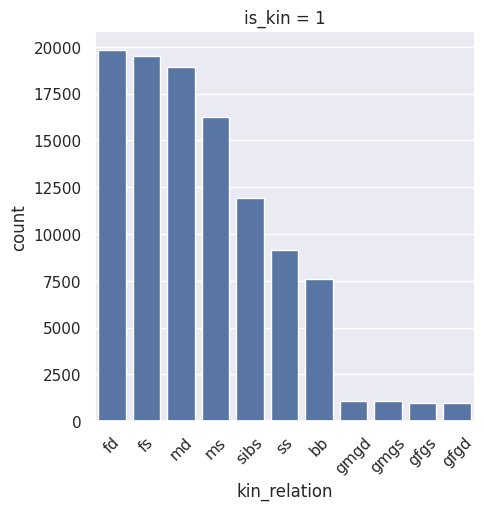

In [42]:
plot_kin_relation_freqs(train_pairs, "Train pairs")

/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


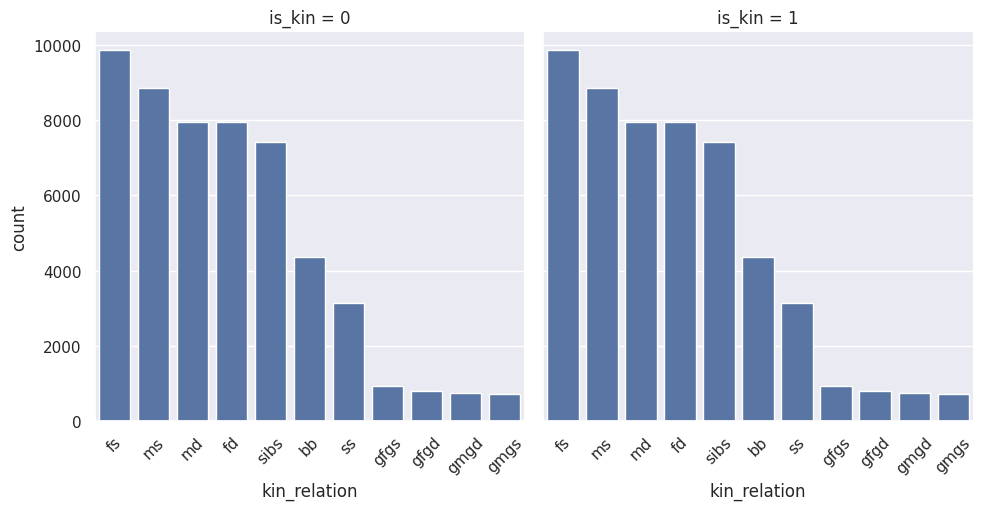

In [43]:
plot_kin_relation_freqs(val_pairs, "Validation pairs")

### Merge age and gender predictions with pairs

In [44]:
def merge_ag_preds_with_pairs(pairs, ag_preds):
    # Add relevant columns to pairs dataframe

    # Processing face1_path
    face1_parts = pairs.face1_path.apply(lambda x: Path(x).parts[-3:])
    pairs[["f1fid", "f1mid", "f1fp"]] = pd.DataFrame(face1_parts.tolist())

    # Processing face2_path
    face2_parts = pairs.face2_path.apply(lambda x: Path(x).parts[-3:])
    pairs[["f2fid", "f2mid", "f2fp"]] = pd.DataFrame(face2_parts.tolist())

    # Merge pairs dataframe with age and gender predictions dataframe
    pairs = pairs.merge(
        ag_preds, left_on=["f1fid", "f1mid", "f1fp"], right_on=["fid", "mid", "pid_filename"], how="inner"
    )
    pairs.rename(columns={"age": "f1_age", "gender": "f1_gender", "gender_score": "f1_gender_score"}, inplace=True)
    pairs.drop(["fid", "mid", "pid_filename"], axis=1, inplace=True)
    pairs = pairs.merge(
        ag_preds, left_on=["f2fid", "f2mid", "f2fp"], right_on=["fid", "mid", "pid_filename"], how="inner"
    )
    pairs.rename(columns={"age": "f2_age", "gender": "f2_gender", "gender_score": "f2_gender_score"}, inplace=True)
    pairs.drop(["fid", "mid", "pid_filename"], axis=1, inplace=True)

    return pairs

In [54]:
train_pairs_ag = merge_ag_preds_with_pairs(train_pairs, train_ag_preds)
val_pairs_ag = merge_ag_preds_with_pairs(val_pairs, val_ag_preds)

## Plot histograms

### Age by face order in the pair, by kinship

In [46]:
import matplotlib.lines as mlines
import seaborn as sns

sns.set_style("whitegrid")

In [51]:
def plot_age_hist_by_face_order_and_kin(pairs, title):
    if len(pairs.is_kin.unique()) == 2:
        g = sns.FacetGrid(pairs, col="is_kin", row="kin_relation", height=2, aspect=3)
    else:
        g = sns.FacetGrid(pairs, row="kin_relation", height=2, aspect=3)
    g = g.map(sns.histplot, "f1_age", color="red", stat="density")
    g = g.map(sns.histplot, "f2_age", color="blue", stat="density")

    # Create custom lines for the legend
    red_line = mlines.Line2D([], [], color="red", label="Face 1")
    blue_line = mlines.Line2D([], [], color="blue", label="Face 2")

    # Adding the legend at the top
    g.fig.legend(handles=[red_line, blue_line], loc="upper center", bbox_to_anchor=[0.5, 1.01], ncol=2)

    plt.suptitle(title, y=1.02)
    plt.show()

/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


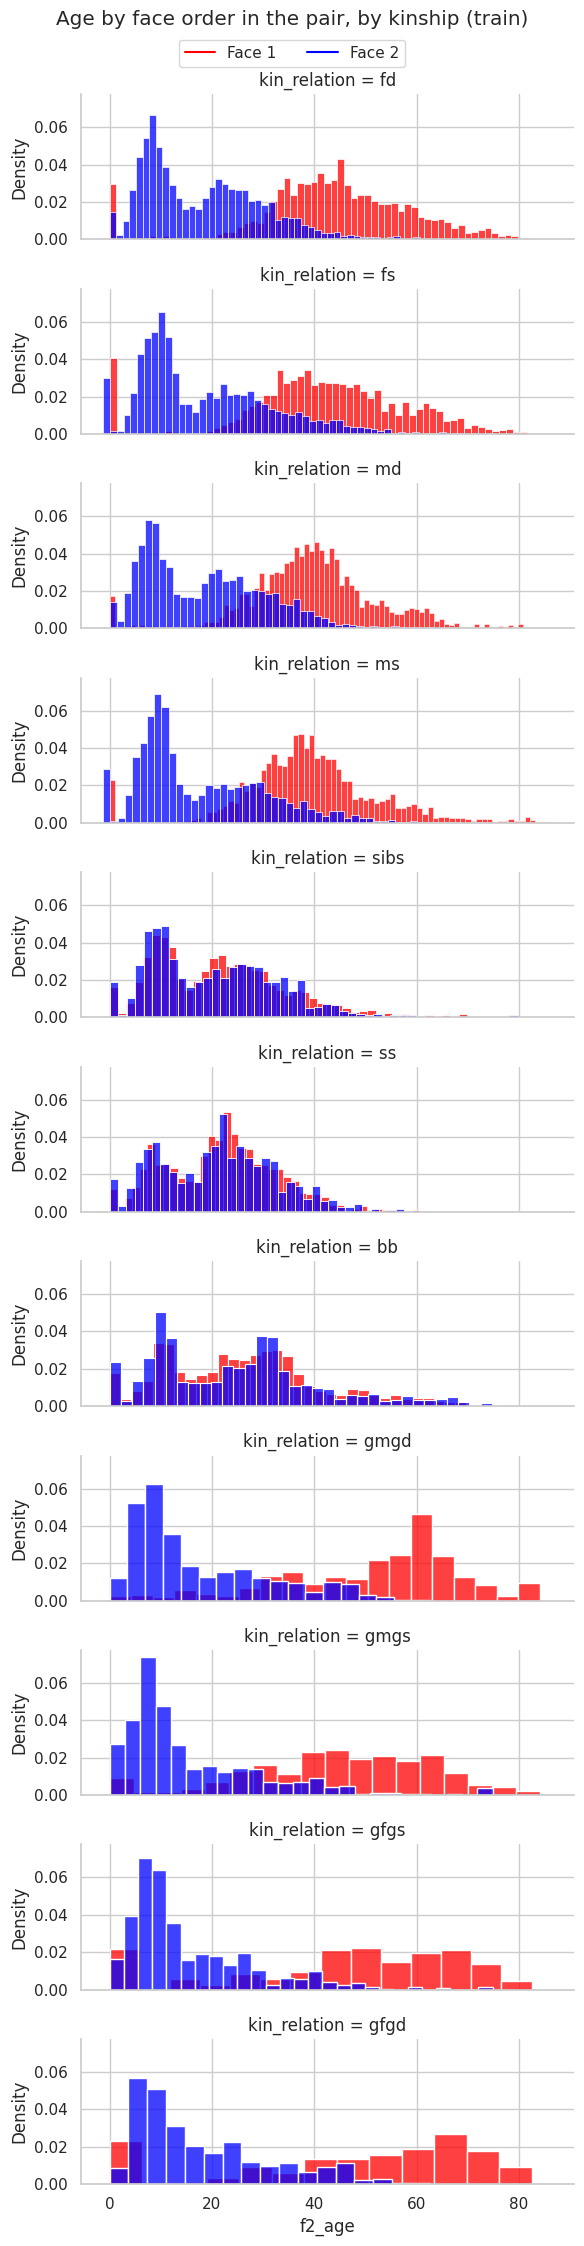

In [55]:
plot_age_hist_by_face_order_and_kin(train_pairs_ag, "Age by face order in the pair, by kinship (train)")

/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


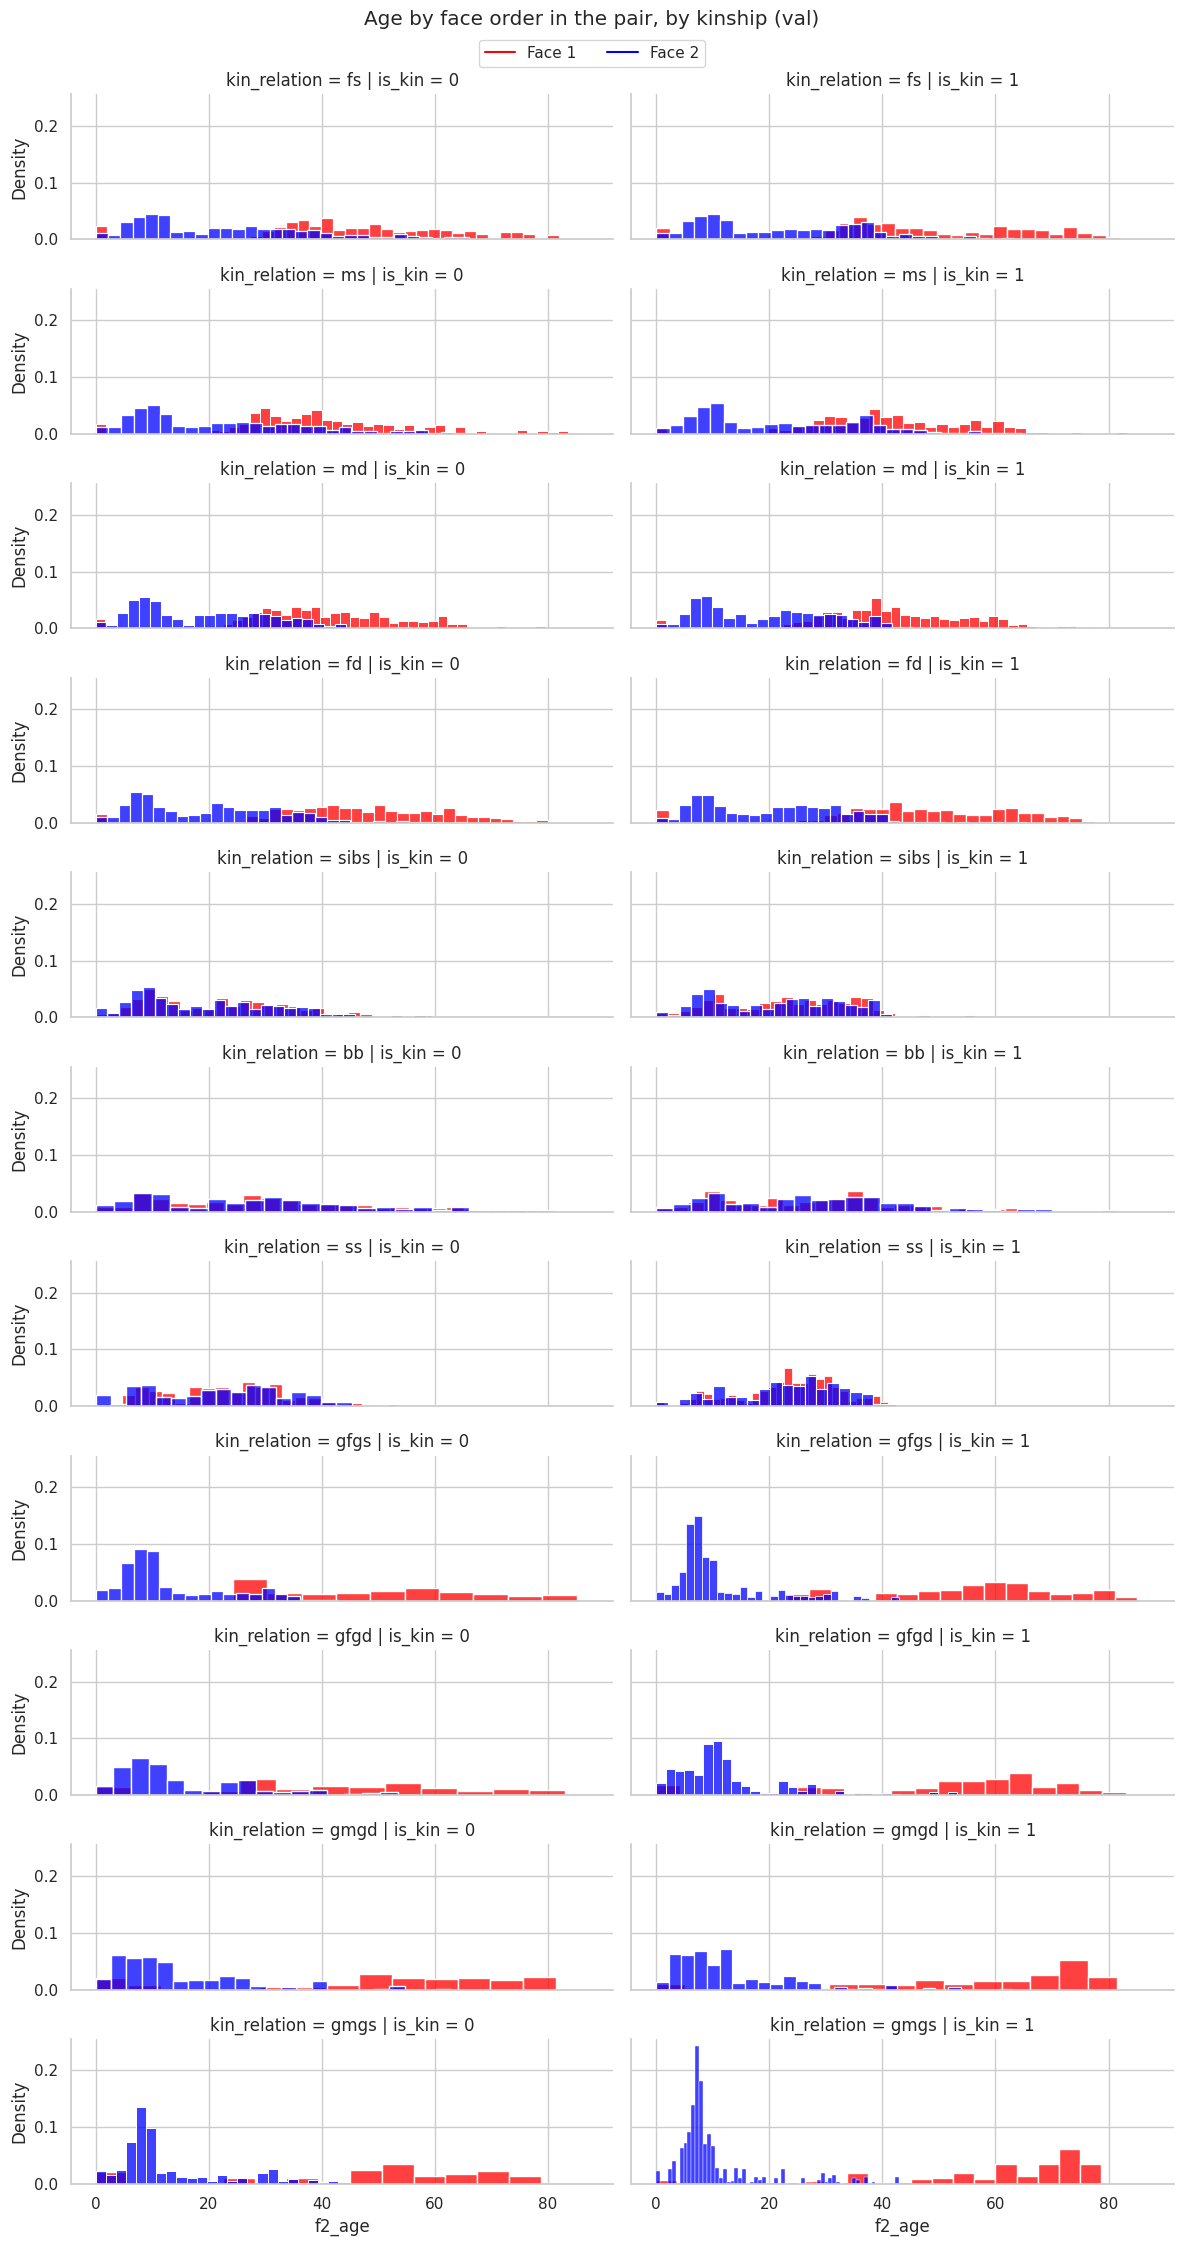

In [56]:
plot_age_hist_by_face_order_and_kin(val_pairs_ag, "Age by face order in the pair, by kinship (val)")

### Compute age difference (delta)

- Keep pairs with age greater than zero.
- Compute absolute difference.

In [89]:
def compute_age_diff(pairs):
    pairs = pairs[(pairs.f1_age > 0) & (pairs.f2_age > 0)]
    pairs["delta_age"] = abs(pairs.f1_age - pairs.f2_age)
    return pairs

In [90]:
train_pairs_ag = compute_age_diff(train_pairs_ag)
val_pairs_ag = compute_age_diff(val_pairs_ag)

### Plot age difference

In [109]:
def plot_age_diff_by_kin(pairs, title):
    def add_legend(data, **kwargs):
        # Calculate mean and standard deviation for this subplot
        mean = data.mean()
        std = data.std()
        legend_label = "mean={:.2f}, std={:.2f}".format(mean, std)

        # Access current axes via plt.gca() and add legend
        ax = plt.gca()
        ax.text(0.5, 0.8, legend_label, transform=ax.transAxes)

    g = sns.FacetGrid(pairs, col="is_kin", row="kin_relation", height=2, aspect=3)
    g = g.map(sns.histplot, "delta_age", color="red", stat="density")
    g = g.map(add_legend, "delta_age")

    plt.suptitle(title, y=1.02)
    plt.show()

/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


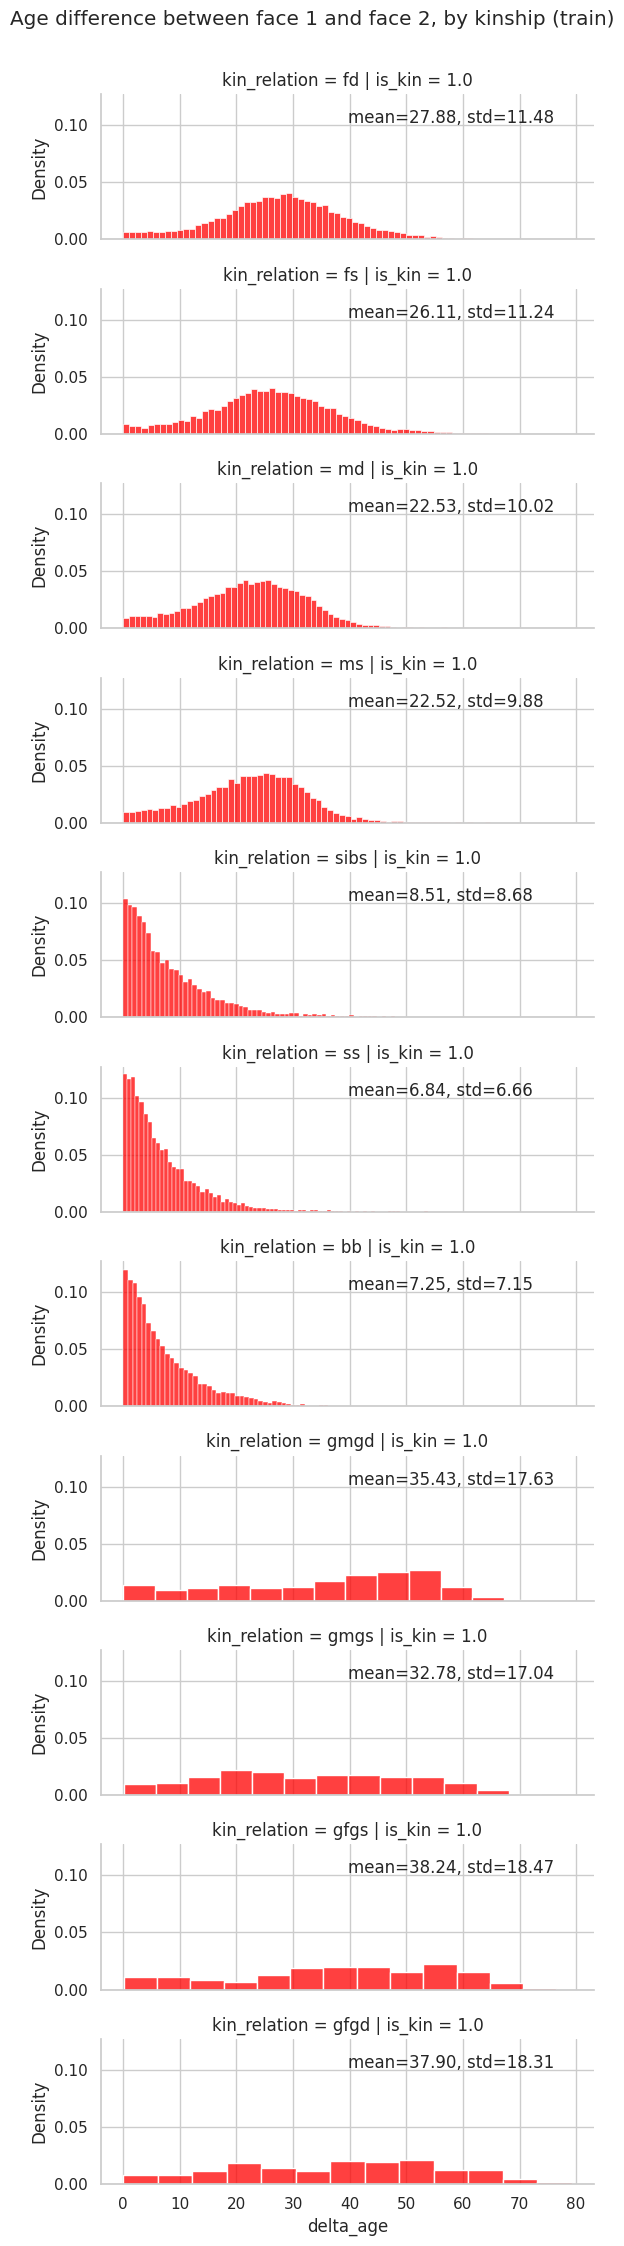

In [110]:
plot_age_diff_by_kin(train_pairs_ag, "Age difference between face 1 and face 2, by kinship (train)")

/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


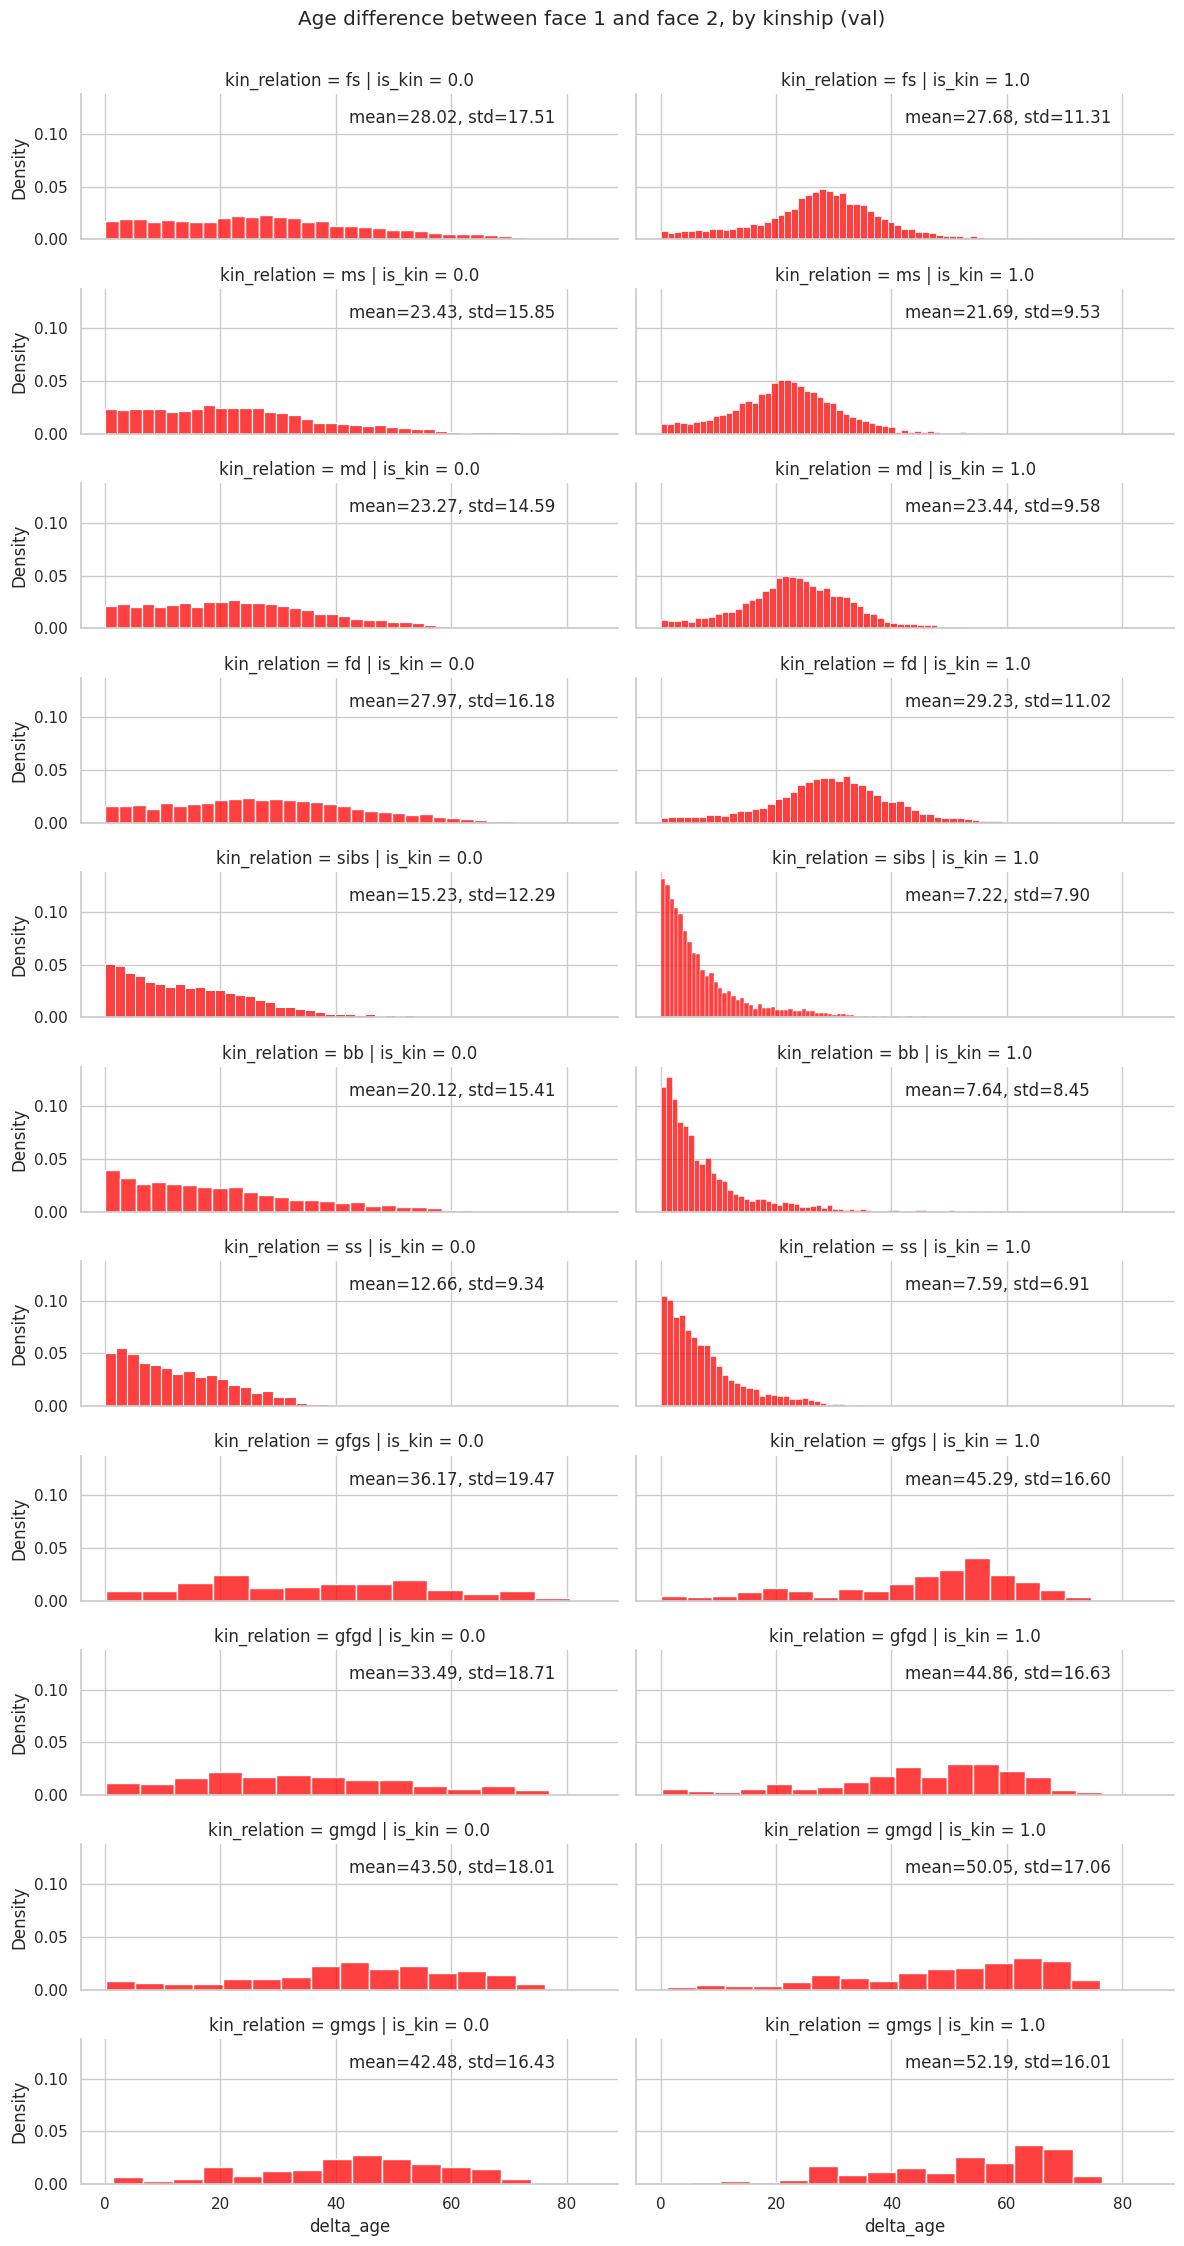

In [111]:
plot_age_diff_by_kin(val_pairs_ag, "Age difference between face 1 and face 2, by kinship (val)")

### Gender by face order in the pair, by kinship

In [94]:
def plot_gender_hist_by_face_order_and_kin(pairs, title):
    g = sns.FacetGrid(pairs, col="is_kin", row="kin_relation", height=2, aspect=3)
    g = g.map(sns.histplot, "f1_gender", color="red", stat="density")
    g = g.map(sns.histplot, "f2_gender", color="blue", stat="density")

    # Create custom lines for the legend
    red_line = mlines.Line2D([], [], color="red", label="Face 1")
    blue_line = mlines.Line2D([], [], color="blue", label="Face 2")

    # Adding the legend at the top
    g.fig.legend(handles=[red_line, blue_line], loc="upper center", bbox_to_anchor=[0.5, 1.01], ncol=2)

    plt.suptitle(title, y=1.02)
    plt.show()

/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


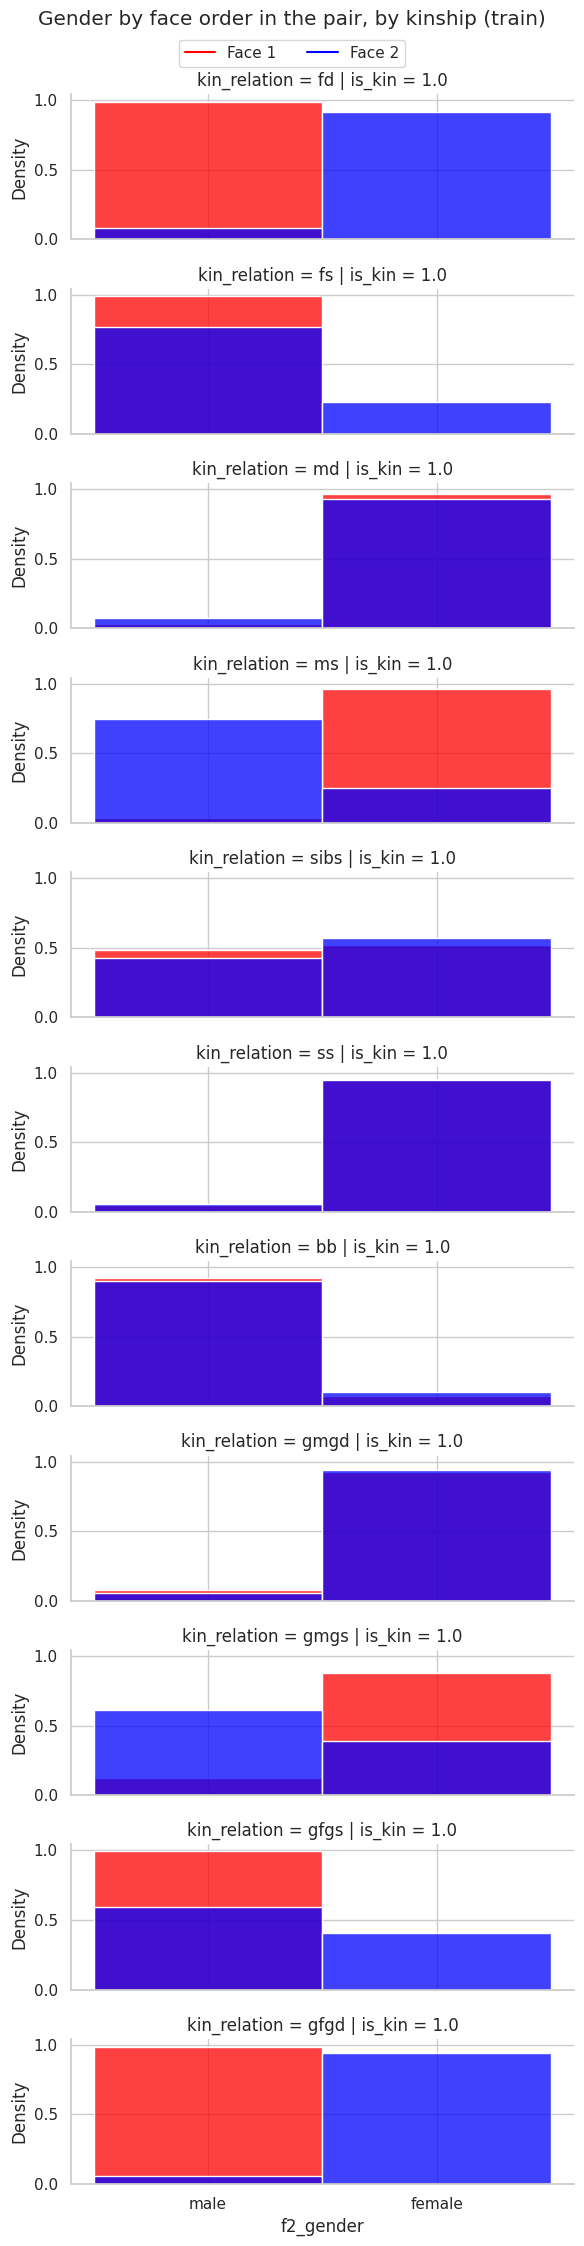

In [95]:
plot_gender_hist_by_face_order_and_kin(train_pairs_ag, "Gender by face order in the pair, by kinship (train)")

/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


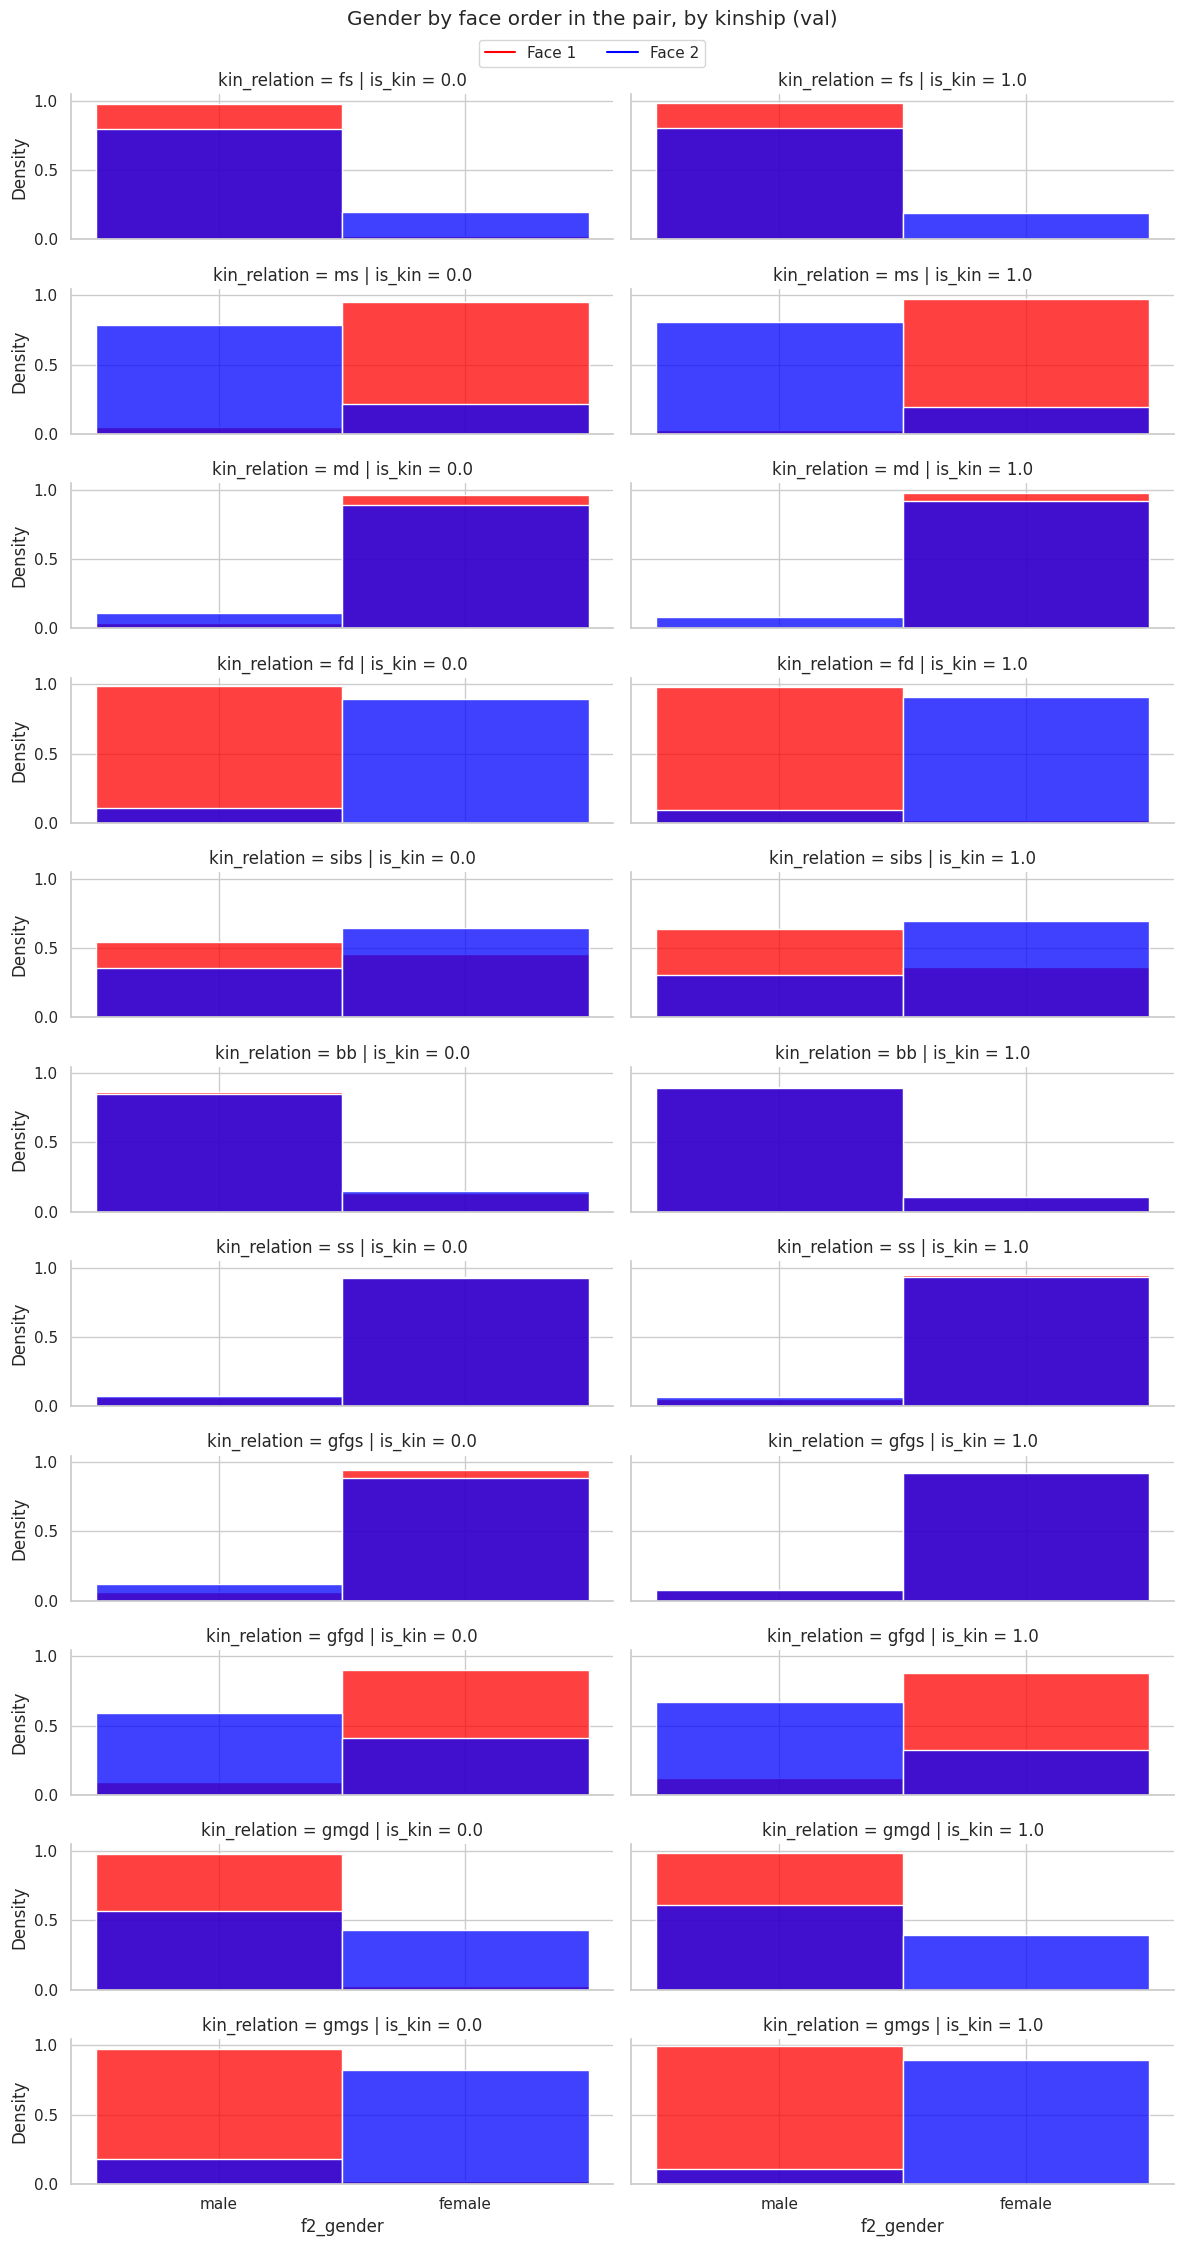

In [96]:
plot_gender_hist_by_face_order_and_kin(val_pairs_ag, "Gender by face order in the pair, by kinship (val)")

- In the above plot note that each y-axis is aggregated as an density, which means that the total area is normalized to 1.

In [113]:
train_pairs_ag.to_csv("data/train_ag.csv", index=False)
val_pairs_ag.to_csv("data/val_ag.csv", index=False)